# Playground Series - S4E4 | Regression with an Abalone Dataset 

## Preparing train set

In [4]:
import pandas as pd
import numpy as np
from sklearn import model_selection

df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_original = pd.read_csv('input/original.csv')

values_to_replace = {'M': 0, 'F': 1, 'I': 2}

df_train.rename(columns={'Whole weight': 'Whole_weight',
                         'Whole weight.1': 'Whole_weight_1',
                         'Whole weight.2': 'Whole_weight_2',
                         'Shell weight': 'Shell_weight'}, inplace=True)
df_test.rename(columns={'Whole weight': 'Whole_weight',
                        'Whole weight.1': 'Whole_weight_1',
                        'Whole weight.2': 'Whole_weight_2',
                        'Shell weight': 'Shell_weight'}, inplace=True)
df_original.rename(columns={'Shucked_weight': 'Whole_weight_1',
                            'Viscera_weight': 'Whole_weight_2'}, inplace=True)

df_train.drop('id', axis=1, inplace=True)
df_original.drop('id', axis=1, inplace=True)
df_train = pd.concat([df_train, df_original], axis=0)

df_train['Sex'] = df_train['Sex'].map(values_to_replace)
df_test['Sex'] = df_test['Sex'].map(values_to_replace)
df_train['kfold'] = -1
df_train = df_train.sample(frac=1).reset_index(drop=True)

kf = model_selection.KFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_train)):
    df_train.loc[val_idx, 'kfold'] = fold

# save the new csv's
df_train.to_csv('input/train_folds.csv', index=False)
df_test.to_csv('input/test.csv', index=False)

df_train.head()

,Sex,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings,kfold
0,0,0.620,0.485,0.195,1.1870,0.5215,0.2695,0.3400,10,0
1,1,0.515,0.435,0.140,0.8720,0.3610,0.1760,0.2385,11,0
2,0,0.505,0.385,0.115,0.5685,0.2410,0.1075,0.1500,8,0
3,2,0.485,0.390,0.125,0.6010,0.2525,0.1320,0.2200,8,0
4,2,0.405,0.280,0.090,0.2885,0.1380,0.0435,0.0765,12,0


## Regression with an Abalone Dataset with tree-base models (baseline)

### Evaluation

In [3]:
import numpy as np

def rmsle_score(y_true, y_pred):
    """
    The Root Mean Squared Log Error (RMSLE) metric using numpy.
    :param y_true: The true targets
    :param y_pred: The predicted targets
    :return: The RMSLE score
    """
    assert len(y_true) == len(y_pred)
    n = len(y_true)
    msle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
    return msle


### Assessing Models

In [6]:
def model_assess(model, title='Default'):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = rmsle_score(y_test, y_pred)
    # print(f'{title} RMSLE: {score:.5f}')
    return score


### Models

In [7]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

SEED = 42
xgb_results = []
xgb_time = []
lgb_results = []
lgb_time = []
cat_results = []
cat_time = []

for fold in range(5):
    df = pd.read_csv('input/train_folds.csv')
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train.drop(['Rings', 'kfold'], axis=1)
    y_train = df_train['Rings']

    X_test = df_valid.drop(['Rings', 'kfold'], axis=1)
    y_test = df_valid['Rings']

    xgb = XGBRegressor(random_state=SEED, device='gpu')
    lgbm = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1)
    cat = CatBoostRegressor(random_state=SEED, verbose=False, allow_writing_files=False)

    start = time.time()
    xgb_score = model_assess(xgb, 'XGB')
    end = time.time()
    xgb_time.append(end - start)
    xgb_results.append(xgb_score)

    start = time.time()
    lgb_score = model_assess(lgbm, 'LGBM')
    end = time.time()
    lgb_time.append(end - start)
    lgb_results.append(lgb_score)

    start = time.time()
    cat_score = model_assess(cat, 'CAT')
    end = time.time()
    cat_time.append(end - start)
    cat_results.append(cat_score)

print(f'XGB Mean RMSLE: {np.mean(xgb_results):.5f} Time: {np.sum(xgb_time):.2f}')
print(f'LGBM Mean RMSLE: {np.mean(lgb_results):.5f} Time: {np.sum(lgb_time):.2f}')
print(f'CAT Mean RMSLE: {np.mean(cat_results):.5f} Time: {np.sum(cat_time):.2f}')


XGB Mean RMSLE: 0.15180 Time: 4.39
LGBM Mean RMSLE: 0.15112 Time: 2.28
CAT Mean RMSLE: 0.15024 Time: 47.34


## Applying All Relevant Features Selections (([ARFS](https://github.com/ThomasBury/arfs))) to the dataset

## GrootCV

Repeated k-fold: 100%|██████████| 25/25 [11:44<00:00, 28.17s/it]


The selected features: ['Sex' 'Length' 'Diameter' 'Height' 'Whole_weight' 'Whole_weight_1'
 'Whole_weight_2' 'Shell_weight']
The agnostic ranking: [2 2 2 2 2 2 2 2]
The naive ranking: ['Height', 'Sex', 'Length', 'Diameter', 'ShadowVar2', 'ShadowVar3', 'ShadowVar4', 'ShadowVar1']


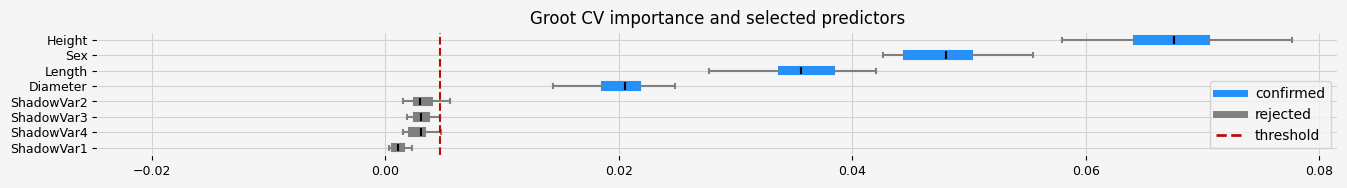

In [11]:
import pandas as pd
import arfs.feature_selection.allrelevant as arfs
import matplotlib.pyplot as plt
import json

from lightgbm import LGBMRegressor
from arfs.benchmark import highlight_tick

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['Rings', 'kfold'], axis=1)
y = df['Rings']

feat_selector = arfs.GrootCV(objective='rmse',
                             cutoff=1,
                             n_folds=5,
                             n_iter=5,
                             silent=True,
                             fastshap=False,
                             n_jobs=0)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# save the results
grootcv_selected_features = feat_selector.get_feature_names_out()
json_file_path = 'grootcv_selected_features.json'
with open(json_file_path, 'w') as json_file:
    json.dump(grootcv_selected_features.tolist(), json_file)

### Leshy

Leshy iteration:   8%|▊         | 8/100 [00:22<04:13,  2.76s/it]




Leshy finished running using native var. imp.

Iteration: 	1 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	6
All relevant predictors selected in 00:00:22.14
The selected features: ['Whole_weight_1' 'Shell_weight']
The agnostic ranking: [7 5 6 4 2 1 3 1]
The naive ranking: ['Shell_weight', 'Whole_weight_1', 'Whole_weight_2', 'Whole_weight', 'Height', 'Length', 'Diameter', 'Sex']


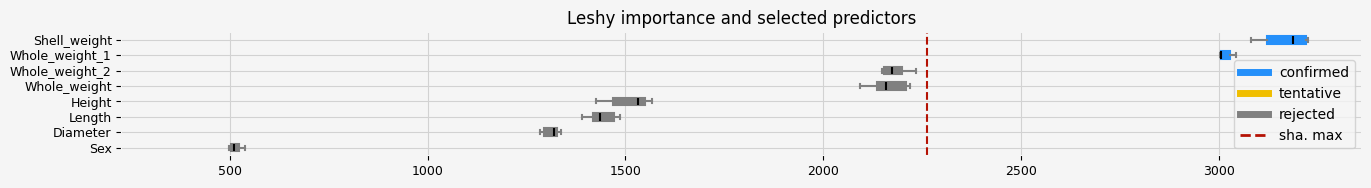

In [13]:
import pandas as pd
import arfs.feature_selection.allrelevant as arfs
import matplotlib.pyplot as plt
import json

from lightgbm import LGBMRegressor
from arfs.benchmark import highlight_tick

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['Rings', 'kfold'], axis=1)
y = df['Rings']

model = LGBMRegressor(random_state=42, verbose=-1)
feat_selector = arfs.Leshy(
    model,
    n_estimators=1000,
    verbose=1,
    max_iter=100,
    random_state=42,
    importance='native'
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# save the results
leshy_selected_features = feat_selector.get_feature_names_out()
json_file_path = 'leshy_selected_features.json'
with open(json_file_path, 'w') as json_file:
    json.dump(leshy_selected_features.tolist(), json_file)


### BoostaGroota

BoostaGRoota round:   0%|          | 0/10 [00:45<?, ?it/s]

The selected features: ['Sex' 'Length' 'Diameter' 'Height' 'Whole_weight' 'Whole_weight_1'
 'Whole_weight_2' 'Shell_weight']
The agnostic ranking: [2 2 2 2 2 2 2 2]
The naive ranking: ['Shell_weight', 'Whole_weight_1', 'Whole_weight', 'Height', 'Sex', 'Whole_weight_2', 'Length', 'Diameter']


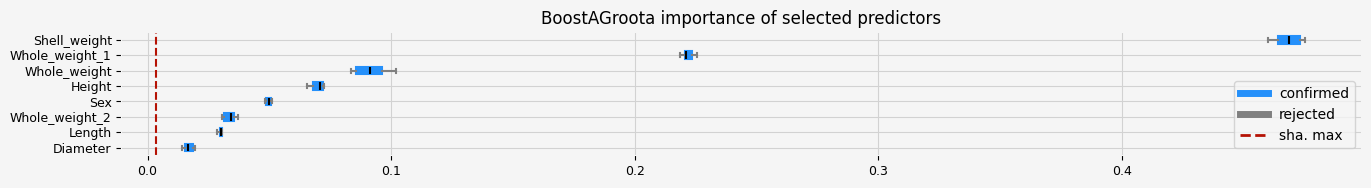

In [14]:
import pandas as pd
import arfs.feature_selection.allrelevant as arfs
import matplotlib.pyplot as plt
import json

from lightgbm import LGBMRegressor
from arfs.benchmark import highlight_tick

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['Rings', 'kfold'], axis=1)
y = df['Rings']

model = LGBMRegressor(random_state=42, verbose=-1)
feat_selector = arfs.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    importance='shap'
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# save the results
boostagroota_selected_features = feat_selector.get_feature_names_out()
json_file_path = 'boostagroota_selected_features.json'
with open(json_file_path, 'w') as json_file:
    json.dump(boostagroota_selected_features.tolist(), json_file)

BoostAGroota and GrootCV methods consider all features important, while Leshy selected only two: Whole_weight_1' and 'Shell_weight'.

In [15]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

SEED = 42
xgb_results = []
xgb_time = []
lgb_results = []
lgb_time = []
cat_results = []
cat_time = []

json_file_path = 'leshy_selected_features.json'
with open(json_file_path, 'r') as json_file:
    selected_features = json.load(json_file)

print(f"Selected features: {selected_features}")
for fold in range(5):
    df = pd.read_csv('input/train_folds.csv')
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train[selected_features]
    y_train = df_train['Rings']

    X_test = df_valid[selected_features]
    y_test = df_valid['Rings']

    xgb = XGBRegressor(random_state=SEED, device='gpu')
    lgbm = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1)
    cat = CatBoostRegressor(random_state=SEED, verbose=False, allow_writing_files=False)

    start = time.time()
    xgb_score = model_assess(xgb, 'XGB')
    end = time.time()
    xgb_time.append(end - start)
    xgb_results.append(xgb_score)

    start = time.time()
    lgb_score = model_assess(lgbm, 'LGBM')
    end = time.time()
    lgb_time.append(end - start)
    lgb_results.append(lgb_score)

    start = time.time()
    cat_score = model_assess(cat, 'CAT')
    end = time.time()
    cat_time.append(end - start)
    cat_results.append(cat_score)

print(f'XGB Mean RMSLE: {np.mean(xgb_results):.5f} Time: {np.sum(xgb_time):.2f}')
print(f'LGBM Mean RMSLE: {np.mean(lgb_results):.5f} Time: {np.sum(lgb_time):.2f}')
print(f'CAT Mean RMSLE: {np.mean(cat_results):.5f} Time: {np.sum(cat_time):.2f}')

Selected features: ['Whole_weight_1', 'Shell_weight']
XGB Mean RMSLE: 0.15716 Time: 2.94
LGBM Mean RMSLE: 0.15619 Time: 1.53
CAT Mean RMSLE: 0.15561 Time: 34.02


**Conclusion**: ARFS methods performed worse than baseline.

## Fine-tuning the hyperParameters with [FLAML](https://microsoft.github.io/FLAML/)

In [18]:
import pandas as pd
from flaml import AutoML
import json

df = pd.read_csv('input/train_folds.csv')

X = df.drop(['Rings', 'kfold'], axis=1)
y = df['Rings']

automl = AutoML()
settings = {
    "time_budget": 300,
    "metric": 'rmse',
    "task": 'regression',
    'estimator_list': ['lgbm', 'xgboost', 'catboost'],
}

automl.fit(X_train=X, y_train=y, **settings)
print('Best hyperparmeter config:', automl.best_config)
print('Best hyperparmeter validation score', automl.best_loss)
print('Training duration of best run: ', automl.best_config_train_time)
print(automl.model.estimator)

# save the results
json_file_path = 'automl_best_config.json'
with open(json_file_path, 'w') as json_file:
    json.dump(automl.best_config_per_estimator, json_file)

[flaml.automl.logger: 04-10 21:34:57] {1680} INFO - task = regression
[flaml.automl.logger: 04-10 21:34:57] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-10 21:34:57] {1789} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 04-10 21:34:57] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.logger: 04-10 21:34:57] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-10 21:34:57] {2345} INFO - Estimated sufficient time budget=2485s. Estimated necessary time budget=4s.
[flaml.automl.logger: 04-10 21:34:57] {2392} INFO -  at 0.2s,	estimator lgbm's best error=2.7167,	best estimator lgbm's best error=2.7167
[flaml.automl.logger: 04-10 21:34:57] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-10 21:34:57] {2392} INFO -  at 0.2s,	estimator lgbm's best error=2.7167,	best estimator lgbm's best error=2.7167
[flaml.automl.logger: 04-10 21:34:57] {2219} INFO - iteration 2, current l

In [22]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

SEED = 42
xgb_results = []
xgb_time = []
lgb_results = []
lgb_time = []
cat_results = []
cat_time = []

json_file_path = 'automl_best_config.json'
with open(json_file_path, 'r') as json_file:
    automl_config = json.load(json_file)

automl_config['lgbm']['random_state'] = SEED
automl_config['xgboost']['random_state'] = SEED
automl_config['catboost']['random_state'] = SEED
automl_config['catboost']['allow_writing_files'] = False

for fold in range(5):
    df = pd.read_csv('input/train_folds.csv')
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train.drop(['Rings', 'kfold'], axis=1)
    y_train = df_train['Rings']

    X_test = df_valid.drop(['Rings', 'kfold'], axis=1)
    y_test = df_valid['Rings']

    xgb = XGBRegressor(**automl_config['xgboost'])
    lgbm = lgb.LGBMRegressor(**automl_config['lgbm'])
    cat = CatBoostRegressor(**automl_config['catboost'])

    start = time.time()
    xgb_score = model_assess(xgb, 'XGB')
    end = time.time()
    xgb_time.append(end - start)
    xgb_results.append(xgb_score)

    start = time.time()
    lgb_score = model_assess(lgbm, 'LGBM')
    end = time.time()
    lgb_time.append(end - start)
    lgb_results.append(lgb_score)

    start = time.time()
    cat_score = model_assess(cat, 'CAT')
    end = time.time()
    cat_time.append(end - start)
    cat_results.append(cat_score)

print(f'XGB Mean RMSLE: {np.mean(xgb_results):.5f} Time: {np.sum(xgb_time):.2f}')
print(f'LGBM Mean RMSLE: {np.mean(lgb_results):.5f} Time: {np.sum(lgb_time):.2f}')
print(f'CAT Mean RMSLE: {np.mean(cat_results):.5f} Time: {np.sum(cat_time):.2f}')

[LightGBM] [Warning] Unknown parameter: log_max_bin
0:	learn: 3.0678197	total: 12.9ms	remaining: 4.13s
1:	learn: 2.9598724	total: 25.4ms	remaining: 4.05s
2:	learn: 2.8655929	total: 35.3ms	remaining: 3.74s
3:	learn: 2.7771374	total: 45.8ms	remaining: 3.63s
4:	learn: 2.7012923	total: 56.3ms	remaining: 3.56s
5:	learn: 2.6315561	total: 66.9ms	remaining: 3.51s
6:	learn: 2.5678069	total: 77.4ms	remaining: 3.47s
7:	learn: 2.5109105	total: 88.3ms	remaining: 3.45s
8:	learn: 2.4617676	total: 99.1ms	remaining: 3.43s
9:	learn: 2.4156839	total: 108ms	remaining: 3.37s
10:	learn: 2.3740390	total: 118ms	remaining: 3.34s
11:	learn: 2.3356087	total: 130ms	remaining: 3.34s
12:	learn: 2.3035569	total: 139ms	remaining: 3.29s
13:	learn: 2.2721611	total: 149ms	remaining: 3.26s
14:	learn: 2.2420409	total: 159ms	remaining: 3.25s
15:	learn: 2.2165336	total: 168ms	remaining: 3.2s
16:	learn: 2.1936048	total: 178ms	remaining: 3.19s
17:	learn: 2.1722937	total: 188ms	remaining: 3.16s
18:	learn: 2.1536645	total: 201m

Analysing the performance of AutoML parameter optimization, we can conclude that only CatBoost regressor surpassed the baseline model. Thus, the CatBoost model with FLAML parameter optimization will be used for test and submission.

## Final train with CatBoost and Submission

In [29]:
import pandas as pd

from catboost import CatBoostRegressor

SEED = 42

json_file_path = 'automl_best_config.json'
with open(json_file_path, 'r') as json_file:
    automl_config = json.load(json_file)

automl_config['catboost']['random_state'] = SEED
automl_config['catboost']['allow_writing_files'] = False

df_train = pd.read_csv('input/train_folds.csv')
df_test = pd.read_csv('input/test.csv')

X_train = df_train.drop(['Rings', 'kfold'], axis=1)
y_train = df_train['Rings']

X_test = df_test.drop(['id'], axis=1)

cat = CatBoostRegressor(**automl_config['catboost'])
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

0:	learn: 3.0610468	total: 7.76ms	remaining: 2.48s
1:	learn: 2.9534934	total: 16.3ms	remaining: 2.6s
2:	learn: 2.8613201	total: 23.7ms	remaining: 2.51s
3:	learn: 2.7732595	total: 32.5ms	remaining: 2.58s
4:	learn: 2.6954865	total: 40.7ms	remaining: 2.57s
5:	learn: 2.6254912	total: 48.3ms	remaining: 2.54s
6:	learn: 2.5609139	total: 58ms	remaining: 2.6s
7:	learn: 2.5016061	total: 67.7ms	remaining: 2.65s
8:	learn: 2.4519769	total: 77.9ms	remaining: 2.7s
9:	learn: 2.4056282	total: 89.2ms	remaining: 2.77s
10:	learn: 2.3643570	total: 101ms	remaining: 2.84s
11:	learn: 2.3258364	total: 112ms	remaining: 2.88s
12:	learn: 2.2909269	total: 123ms	remaining: 2.92s
13:	learn: 2.2607000	total: 137ms	remaining: 3s
14:	learn: 2.2330750	total: 149ms	remaining: 3.05s
15:	learn: 2.2084914	total: 161ms	remaining: 3.08s
16:	learn: 2.1863444	total: 171ms	remaining: 3.05s
17:	learn: 2.1660588	total: 181ms	remaining: 3.05s
18:	learn: 2.1467884	total: 193ms	remaining: 3.07s
19:	learn: 2.1287129	total: 204ms	remai

In [33]:
submission = pd.read_csv('input/sample_submission.csv') 

submission.iloc[:, 1] = y_pred

submission.to_csv('submission.csv', index=False)

submission.head()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_12040\1484030416.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9.33999463  9.70486632 10.29329303 ... 12.12191036 13.53121873
  8.75394076]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.iloc[:, 1] = y_pred


,id,Rings
0,90615,9.339995
1,90616,9.704866
2,90617,10.293293
3,90618,10.374045
4,90619,7.580000


In [34]:
! kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Fist Submission"

Successfully submitted to Regression with an Abalone Dataset



  0%|          | 0.00/1.50M [00:00<?, ?B/s]
  1%|          | 16.0k/1.50M [00:01<02:48, 9.26kB/s]
 48%|████▊     | 736k/1.50M [00:01<00:01, 558kB/s]  
100%|██████████| 1.50M/1.50M [00:03<00:00, 459kB/s]
